In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, math, torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
torch.manual_seed(42)


In [3]:
# Load the dataset (Assuming you've already preprocessed the data)
rides_2021 = pd.read_parquet("C:/Users/mahar/Downloads/Capstone for Models/cpz_station_timeseries_2021_yearly_15min.parquet")
rides_2022 = pd.read_parquet("C:/Users/mahar/Downloads/Capstone for Models/cpz_station_timeseries_2022_yearly_15min.parquet")
rides_2023 = pd.read_parquet("C:/Users/mahar/Downloads/Capstone for Models/cpz_station_timeseries_2023_yearly_15min.parquet")
rides_2024 = pd.read_parquet("C:/Users/mahar/Downloads/Capstone for Models/cpz_station_timeseries_2024_yearly_15min.parquet")

In [4]:
rides = pd.concat([rides_2021, rides_2022, rides_2023, rides_2024], ignore_index=True)
rides["time_bucket"] = pd.to_datetime(rides["time_bucket"])
rides["date"] = rides["time_bucket"].dt.date

daily = (rides.groupby(["start_station_id", "date"])["booking_count"]
               .sum()
               .reset_index())

In [5]:
urban = (pd.read_csv("C:/Users/mahar/Downloads/Capstone for Models/proximity_summary_by_station.csv")
           .rename(columns={"station_id":"start_station_id"}))

public = (pd.read_csv("C:/Users/mahar/Downloads/Capstone for Models/Summary_using_urban_features.csv")
            .rename(columns={"station_id":"start_station_id"}))

osm = (pd.read_csv("C:/Users/mahar/Downloads/station_osm_surroundings.csv")
         .rename(columns={"station_id":"start_station_id"}))

coords = pd.read_csv("C:/Users/mahar/Downloads/Capstone for Models/manhattan_stations_.csv")

In [6]:
print(urban.shape)
print(public.shape)
print(osm.shape)
print(coords.shape)


(1715, 5)
(1715, 6)
(1715, 5)
(1715, 4)


In [7]:
static_feats = (urban
                .merge(public, on="start_station_id", how="outer")
                .merge(osm,    on="start_station_id", how="outer")
                .merge(coords, on="start_station_id", how="outer"))


In [8]:
weather = pd.read_csv("C:/Users/mahar/Downloads/Capstone for Models/final_weather_dataset (1) (1).csv")
weather["DATE"] = pd.to_datetime(weather["DATE"]).dt.date
weather_num = weather.drop(columns=["WEATHER_CATEGORY"])
weather_cat = pd.get_dummies(weather["WEATHER_CATEGORY"], prefix="wx")
weather     = pd.concat([weather_num, weather_cat], axis=1)


In [9]:
# 2. MERGE AND PREP
# =============================================================================
station_id = "4818.03"

df = daily[daily["start_station_id"] == station_id].copy()
df = df.merge(static_feats, on="start_station_id", how="left")
df = df.merge(weather, left_on="date", right_on="DATE", how="left").drop(columns=["DATE"])
df.sort_values("date", inplace=True)
df.reset_index(drop=True, inplace=True)


In [10]:
# Outlier removal
q1, q3 = df["booking_count"].quantile([0.25, 0.75])
iqr = q3 - q1
df = df[(df["booking_count"] >= q1-1.5*iqr) & (df["booking_count"] <= q3+1.5*iqr)]

# Normalize target
y_scaler = StandardScaler()
df["booking_norm"] = y_scaler.fit_transform(df[["booking_count"]])

# Build covariates correctly
num_cols = (df.select_dtypes("number")
              .drop(columns=["booking_count", "booking_norm"])
              .columns)

df[num_cols] = df[num_cols].fillna(0.0)
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

target = df["booking_norm"].astype("float32").values
covariates = df[num_cols].astype("float32").values
dates = pd.to_datetime(df["date"])


In [11]:
# 3. SPLIT DATA
# =============================================================================
train_end = int(len(df)*0.70)
val_end   = int(len(df)*0.85)

train_y, val_y, test_y = target[:train_end], target[train_end:val_end], target[val_end:]
train_c, val_c, test_c = covariates[:train_end], covariates[train_end:val_end], covariates[val_end:]

context, horizon = 30, 1

class SeqDS(Dataset):
    def __init__(self, y, c, ctx, h):
        self.y, self.c, self.ctx, self.h = y, c, ctx, h
    def __len__(self): return len(self.y) - self.ctx - self.h + 1
    def __getitem__(self, idx):
        s, e = idx, idx+self.ctx
        hist = np.column_stack([self.y[s:e], self.c[s:e]])
        fut_c= self.c[e:e+self.h]
        fut_y= self.y[e:e+self.h]
        return torch.tensor(hist), torch.tensor(fut_c), torch.tensor(fut_y)

train_ds = SeqDS(train_y, train_c, context, horizon)
val_ds   = SeqDS(np.concatenate([train_y[-context:], val_y]),
                 np.vstack([train_c[-context:], val_c]),
                 context, horizon)

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl   = DataLoader(val_ds, batch_size=64)


In [12]:
# ============================
# 4. MODEL
# ============================

input_size = 1 + covariates.shape[1]   # booking_norm + covariates
hidden, layers = 64, 2

class DeepAR(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.GRU(input_size, hidden, layers, batch_first=True)
        self.mu = nn.Linear(hidden, 1)
        self.sig = nn.Linear(hidden, 1)

    def forward(self, x_ctx, x_fut):
        out, h = self.rnn(x_ctx)
        mus, sigs = [], []

        last = x_ctx[:, -1:, :]  # shape: [B, 1, D] — unsqueeze already included

        for t in range(x_fut.size(1)):
            out, h = self.rnn(last, h)
            mu_t = self.mu(out.squeeze(1))
            sig_t = F.softplus(self.sig(out.squeeze(1))) + 1e-6
            sig_t = torch.clamp(sig_t, min=1e-2, max=5.0)

            mus.append(mu_t)
            sigs.append(sig_t)

            # Prepare next input: [mu | covariates] → shape: [B, 1, D]
            last = torch.cat([mu_t.unsqueeze(1), x_fut[:, t:t+1, :]], dim=2)

        return torch.stack(mus, 1).squeeze(-1), torch.stack(sigs, 1).squeeze(-1)

# Instantiate model
model = DeepAR().to("cpu")
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# Define NLL loss
def nll(mu, sig, y):
    sig = torch.clamp(sig, min=1e-2, max=5.0)
    return ((y - mu)**2 / (2 * sig**2) + torch.log(sig)).mean()


In [13]:
# 5. TRAINING (EARLY STOPPING)
# =============================================================================
EPOCHS = 100
patience = 10
best_val_nll = np.inf
patience_counter = 0

for epoch in range(1, EPOCHS+1):
    model.train()
    train_loss = 0.0
    for x_ctx, x_fut, y in train_dl:
        mu, sig = model(x_ctx.float(), x_fut.float())
        loss = nll(mu.squeeze(), sig.squeeze(), y.float().squeeze())
        opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        opt.step()
        train_loss += loss.item() * len(x_ctx)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_ctx, x_fut, y in val_dl:
            mu, sig = model(x_ctx.float(), x_fut.float())
            val_loss += nll(mu.squeeze(), sig.squeeze(), y.float().squeeze()).item() * len(x_ctx)
    
    train_nll = train_loss / len(train_ds)
    val_nll = val_loss / len(val_ds)

    print(f"Epoch {epoch:03d}/{EPOCHS}  •  Train NLL {train_nll:.4f}  •  Val NLL {val_nll:.4f}")

    if val_nll < best_val_nll:
        best_val_nll = val_nll
        patience_counter = 0
        best_model_state = model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\n Early stopping at epoch {epoch}")
            break

model.load_state_dict(best_model_state)


Epoch 001/100  •  Train NLL -0.7554  •  Val NLL -0.9955
Epoch 002/100  •  Train NLL -0.9806  •  Val NLL -0.4948
Epoch 003/100  •  Train NLL -0.9936  •  Val NLL -0.8798
Epoch 004/100  •  Train NLL -1.0859  •  Val NLL -0.9874
Epoch 005/100  •  Train NLL -0.9998  •  Val NLL -1.0096
Epoch 006/100  •  Train NLL -1.1639  •  Val NLL -0.9234
Epoch 007/100  •  Train NLL -1.0897  •  Val NLL -0.8255
Epoch 008/100  •  Train NLL -1.2112  •  Val NLL -0.2769
Epoch 009/100  •  Train NLL -1.2162  •  Val NLL -0.7619
Epoch 010/100  •  Train NLL -1.1661  •  Val NLL -1.0017
Epoch 011/100  •  Train NLL -1.3554  •  Val NLL -0.6303
Epoch 012/100  •  Train NLL -1.3474  •  Val NLL -1.2210
Epoch 013/100  •  Train NLL -1.4138  •  Val NLL -0.8693
Epoch 014/100  •  Train NLL -1.4853  •  Val NLL -1.3057
Epoch 015/100  •  Train NLL -1.3482  •  Val NLL -0.4482
Epoch 016/100  •  Train NLL -1.5705  •  Val NLL -0.6923
Epoch 017/100  •  Train NLL -1.6672  •  Val NLL -0.9049
Epoch 018/100  •  Train NLL -1.6841  •  Val NLL 

<All keys matched successfully>

In [14]:
num_cols = (df.select_dtypes("number")
              .drop(columns=["booking_count", "booking_norm"])   # DROP BOTH
              .columns)

covariates = df[num_cols].astype("float32").values


In [15]:
print("Shape of covariates:", covariates.shape)
print("Number of features in covariates:", covariates.shape[1])

print("Model input size (expected):", model.rnn.input_size)

print("Stationary context window:", context)

# Now show me sample 1 input
print("Sample x_ctx input:")
print(np.column_stack([target[-context:], covariates[-context:]]).shape)


Shape of covariates: (22768, 26)
Number of features in covariates: 26
Model input size (expected): 27
Stationary context window: 30
Sample x_ctx input:
(30, 27)


In [75]:
print("🟢 covariates[val_end:test_end].shape =", covariates[val_end:test_end].shape)
print("🟢 test_y.shape =", test_y.shape)

# Create dummy column
dummy = np.zeros((test_y.shape[0], 1), dtype=np.float32)

# Combine dummy + test covariates to form correct shape
x_fut = np.concatenate([dummy, covariates[val_end:test_end]], axis=1)

# Print shape before forecasting
print("✅ x_fut.shape (should be N, 27):", x_fut.shape)


🟢 covariates[val_end:test_end].shape = (3416, 26)
🟢 test_y.shape = (3416,)
✅ x_fut.shape (should be N, 27): (3416, 27)


In [88]:
def forecast(x_ctx, x_fut):
    model.eval()
    with torch.no_grad():
        # NO additional stacking inside
        print("🚨 x_ctx shape:", x_ctx.shape)
        print("🚨 x_fut shape:", x_fut.shape)

        x_ctx_tensor = torch.tensor(x_ctx, dtype=torch.float32).unsqueeze(0)  # shape: [1, 30, 27]
        x_fut_tensor = torch.tensor(x_fut, dtype=torch.float32).unsqueeze(0)  # shape: [1, N, 27]

        mu, sig = model(x_ctx_tensor, x_fut_tensor)
        return mu.squeeze(0).numpy(), sig.squeeze(0).numpy()


In [89]:
# === 90-day Forecast Generation ===
look_ahead = 90
test_end = len(target)

# Future date range
future_dates = pd.date_range(dates.iloc[test_end - 1] + pd.Timedelta(days=1), periods=look_ahead)

# Extract last 30 days of context input
# Build x_ctx correctly (27 features = booking + 26 covariates)
x_ctx = np.column_stack([target[-context:].reshape(-1, 1), covariates[-context:]])

mu90, sig90 = forecast(x_ctx, future_cov)  # Pass only 2 args

# Extract real covariates for 90 days (no dummy column)
future_cov = covariates[-look_ahead:]         # shape: (90, 26)

# ✅ Call forecast correctly (pass all 3 arguments)
mu90, sig90 = forecast(x_ctx, future_cov)  # Pass only 2 args

# Inverse transform to original booking scale
mu90_real = y_scaler.inverse_transform(mu90.reshape(-1, 1)).ravel()
sig90_real = y_scaler.inverse_transform(sig90.reshape(-1, 1)).ravel()

# ✅ Print confirmation
print("✅ Forecast completed. First 5 real values:", mu90_real[:5])


🚨 x_ctx shape: (30, 27)
🚨 x_fut shape: (90, 26)
🚨 x_ctx shape: (30, 27)
🚨 x_fut shape: (90, 26)
✅ Forecast completed. First 5 real values: [40.988335 38.135548 32.93056  28.622553 28.297829]


In [91]:

n = len(target)  # total number of rows

train_frac = 0.7
val_frac = 0.15
test_frac = 0.15

train_end = int(n * train_frac)
val_end = int(n * (train_frac + val_frac))
test_end = n

# create splits
train_y = target[:train_end]
val_y = target[train_end:val_end]
test_y = target[val_end:test_end]


In [93]:
# 🧠 Prepare past 30 days for context input
x_ctx_test = np.column_stack([
    target[val_end - context:val_end].reshape(-1, 1),      # shape: (30, 1)
    covariates[val_end - context:val_end]                  # shape: (30, 26)
])  # Final shape: (30, 27)

# ✅ Remove booking_norm (first column) to avoid duplicate
cov_test_only = covariates[val_end:test_end, 1:]          # shape: (3416, 26)

# 🧱 Add dummy booking_norm column (shape must match)
dummy = np.zeros((test_y.shape[0], 1), dtype=np.float32)  # shape: (3416, 1)

# 🔗 Combine dummy + covariates → final x_fut
x_fut_test = np.concatenate([dummy, cov_test_only], axis=1)  # shape: (3416, 27)

# 🧪 Call forecast
mu_test, sig_test = forecast(x_ctx_test, x_fut_test)

# ✅ Confirm shapes
print("🟩 x_ctx shape:", x_ctx_test.shape)
print("🟩 x_fut shape:", x_fut_test.shape)
print("🟩 Model input size:", model.rnn.input_size)


🚨 x_ctx shape: (30, 27)
🚨 x_fut shape: (3416, 26)
🟩 x_ctx shape: (30, 27)
🟩 x_fut shape: (3416, 26)
🟩 Model input size: 27


In [94]:
# Reverse normalization
mu_test_real = y_scaler.inverse_transform(mu_test.reshape(-1, 1)).ravel()
sig_test_real = y_scaler.inverse_transform(sig_test.reshape(-1, 1)).ravel()

# Print forecast preview
print("✅ Forecast complete. First 5 real values:", mu_test_real[:5])


✅ Forecast complete. First 5 real values: [41.48138  42.13761  41.328053 41.77243  41.204857]


In [95]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Reverse scale predictions and ground truth
mu_test_real = y_scaler.inverse_transform(mu_test.reshape(-1, 1)).ravel()
sig_test_real = y_scaler.inverse_transform(sig_test.reshape(-1, 1)).ravel()
test_y_real = y_scaler.inverse_transform(target[val_end:test_end].reshape(-1, 1)).ravel()

# Confirm shapes
print("Expected model input size:", model.rnn.input_size)
print("✅ x_ctx shape going in:", x_ctx_test.shape)
print("✅ x_fut shape going in:", x_fut_test.shape)

# 📊 Compute Metrics
mae = mean_absolute_error(test_y_real, mu_test_real)
mse = mean_squared_error(test_y_real, mu_test_real)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test_y_real - mu_test_real) / test_y_real)) * 100

# 📋 Print Results
print("\n✅ Test Set Metrics")
print(f"MAE  = {mae:.3f}")
print(f"MSE  = {mse:.3f}")
print(f"RMSE = {rmse:.3f}")
print(f"MAPE = {mape:.2f}%")


Expected model input size: 27
✅ x_ctx shape going in: (30, 27)
✅ x_fut shape going in: (3416, 26)

✅ Test Set Metrics
MAE  = 10.209
MSE  = 161.883
RMSE = 12.723
MAPE = 111.41%


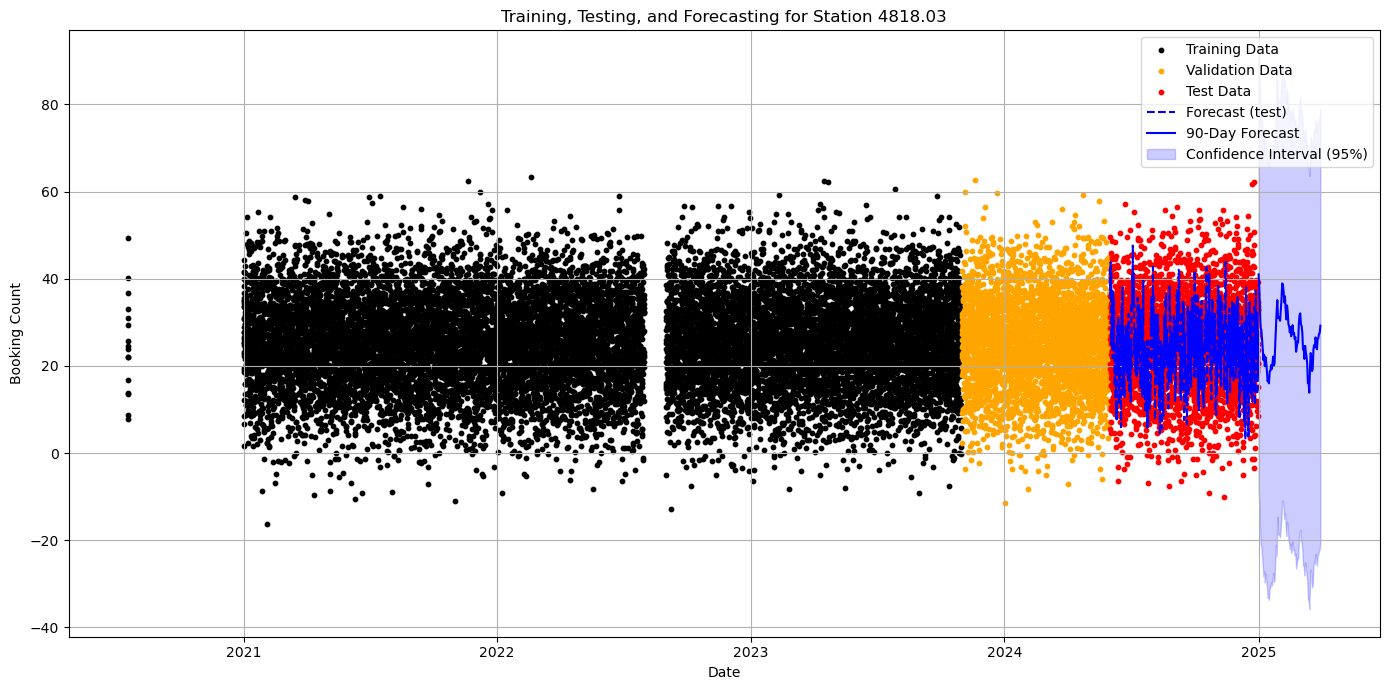

In [96]:
import matplotlib.pyplot as plt

# Create 90-day future dates
look_ahead = 90
future_dates = pd.date_range(dates.iloc[test_end - 1] + pd.Timedelta(days=1), periods=look_ahead)

# Inverse transform future predictions and uncertainty
mu90_real = y_scaler.inverse_transform(mu90.reshape(-1, 1)).ravel()
sig90_real = y_scaler.inverse_transform(sig90.reshape(-1, 1)).ravel()

# Plot
plt.figure(figsize=(14, 7))

# Plot training data
plt.scatter(dates[:train_end], y_scaler.inverse_transform(target[:train_end].reshape(-1,1)), label="Training Data", color="black", s=10)

# Plot validation data
plt.scatter(dates[train_end:val_end], y_scaler.inverse_transform(target[train_end:val_end].reshape(-1,1)), label="Validation Data", color="orange", s=10)

# Plot test data
plt.scatter(dates[val_end:test_end], y_scaler.inverse_transform(target[val_end:test_end].reshape(-1,1)), label="Test Data", color="red", s=10)

# Plot test forecast
plt.plot(dates[val_end:test_end], mu_test_real, label="Forecast (test)", color="blue", linestyle="--")

# Plot future forecast
plt.plot(future_dates, mu90_real, label="90-Day Forecast", color="blue")

# Confidence interval
plt.fill_between(future_dates,
                 mu90_real - 1.96 * sig90_real,
                 mu90_real + 1.96 * sig90_real,
                 color="blue", alpha=0.2, label="Confidence Interval (95%)")

# Final touches
plt.title(f"Training, Testing, and Forecasting for Station {station_id}")
plt.xlabel("Date")
plt.ylabel("Booking Count")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
